# 3상모터 전류 데이터 정보

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os
from collections import Counter

from model.pytorch.lstm.dataset import load_csv

/usr/local/lib/python3.6/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
dataset_path = glob(os.path.join('dataset/current/train', '**/*.csv'), recursive=True)

In [40]:
classes = [ os.path.dirname(path).split('/')[-1] for path in dataset_path ]

### 클래스 종류 및 클래스 개수

In [70]:
num_classes = len(set(classes))
print('classes: ', set(classes))
print('number of classes: ' , num_classes)

classes:  {'def_shaft_alignment', 'normal', 'loose_belt', 'def_baring', 'rotating_unbalance'}
number of classes:  5


### 데이터 샘플

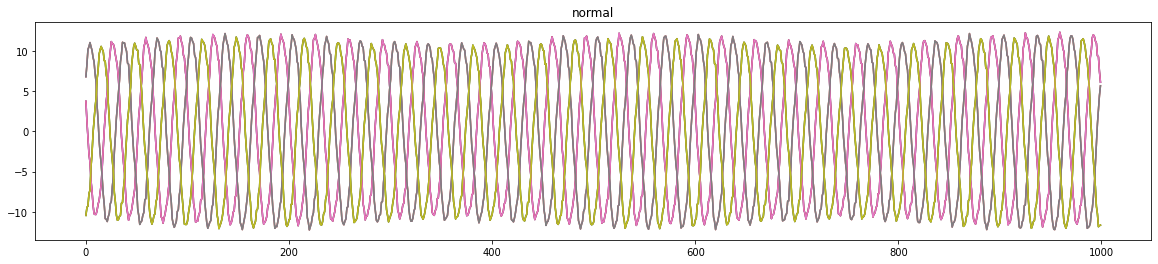

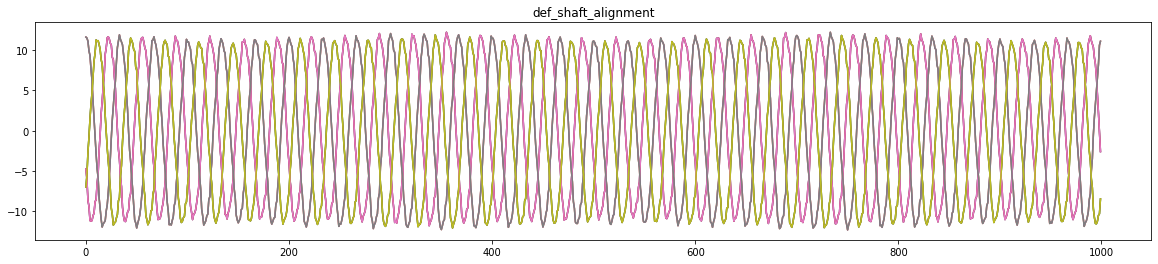

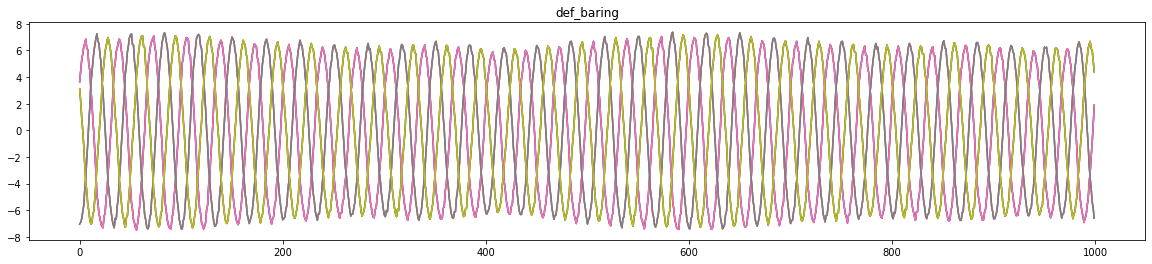

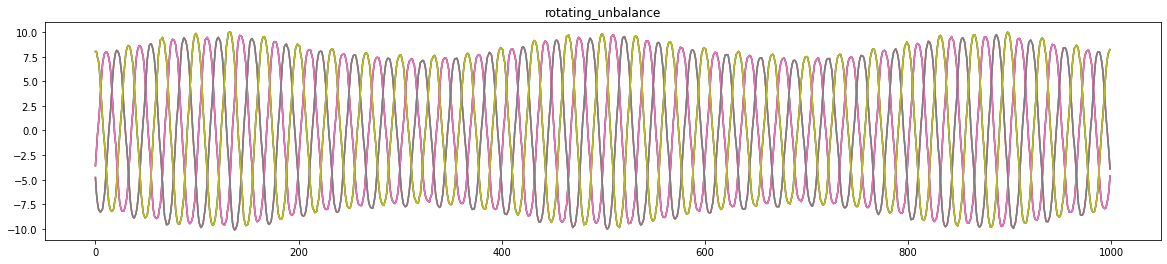

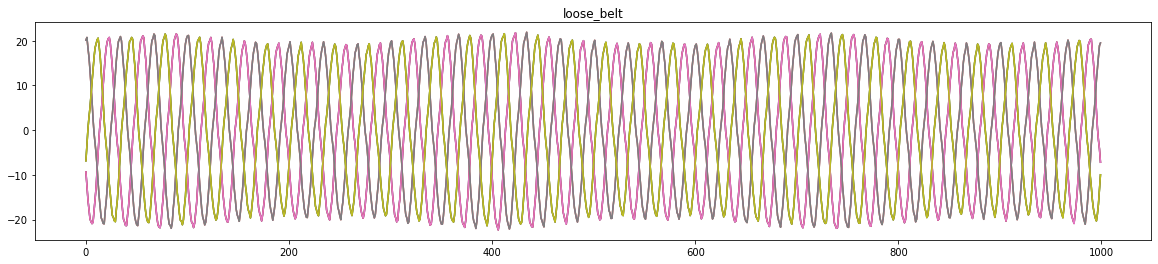

In [82]:
show_classes = []
for class_name, path in zip(classes, dataset_path):
    if class_name in show_classes:
        continue
    
    show_classes.append(class_name)
    
    csv = load_csv(path)   
    plt.figure(figsize=(20,4))
    plt.title(class_name)
    for col in range(3):
        plt.plot(csv[0][:1000, :])
    plt.show()
    
    if len(show_classes) == num_classes: break

### 데이터 개수

In [183]:
'total data: ', len(dataset_path)

('total data: ', 141047)

In [193]:
c = Counter(classes)
x = list(c.values())
y = list(c.keys())

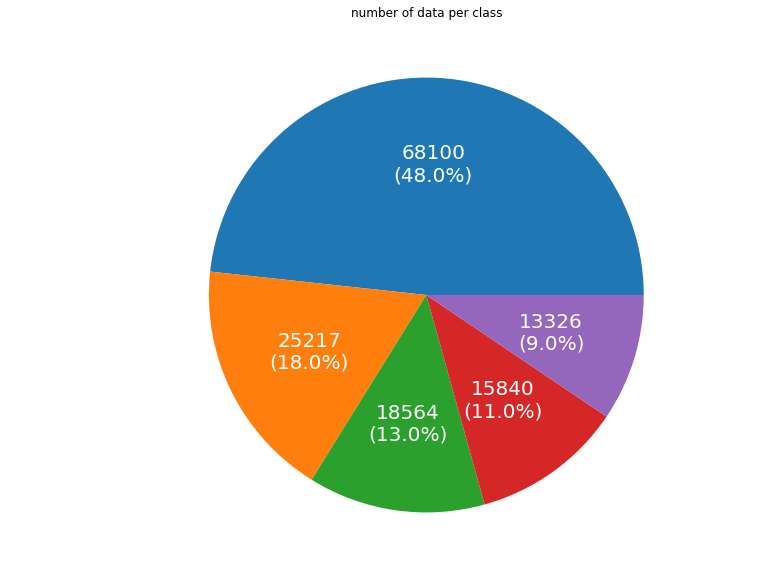

In [199]:
def absolute_value(val):
    a  = np.round(val/100. * sum(x), 0)
    return '{}\n({}%)'.format(int(a), np.round(val,0))

plt.figure(figsize=(10, 10))
plt.title('number of data per class')
plt.pie(x,labels = y, autopct=absolute_value, textprops={'color':"w", 'fontsize': 20})
plt.show()

# 모델 학습
* --dataset-path 학습 데이터셋의 이미지 폴더 위치 지정
* --num-epochs 학습 횟수
* --batch-size 배치 사이즈
* --lr 런닝레이트 지정
* --checkpoints-path 모델 저장 위치
    * 10 epoch 단위로 model_epoch_{EPOCH_INDEX}.pt 파일로 저장
    * 마지막 학습 결과는 model_epoch_latest.pt 라는 이름으로 저장됨

In [184]:
!python3 model/pytorch/lstm/train.py \
--dataset-path 'dataset/current/train' \
--checkpoints-path 'check_points/lstm' \
--lr 0.001 \
--batch-size 512 \
--num-epochs 2

logging file path : check_points/lstm/train.log
training device : cuda
Namespace(batch_size=512, checkpoints_path='check_points/lstm', cpus=-1, dataset_path='dataset/current/train', epochs=2, lr=0.001, name='lstm', random_seed=45, use_cpu=False)
data size - trn : 112837, val : 28210
loaded weight: check_points/lstm/model_state_dict_best.pt
100%|#############################| 221/221 [00:46<00:00,  4.78it/s, loss=0.104]
trn Epoch:  1, time : 46.26, loss : 0.1924, f1-score : 0.9261
100%|#############################################| 3/3 [00:40<00:00, 13.63s/it]
best f1! save model. check_points/lstm/model_state_dict_best.pt
val Epoch:  1, time : 40.92, loss : 0.0018, f1-score : 0.9453
100%|#############################| 221/221 [00:45<00:00,  4.90it/s, loss=0.168]
trn Epoch:  2, time : 45.10, loss : 0.1560, f1-score : 0.9365
100%|#############################################| 3/3 [00:39<00:00, 13.17s/it]
val Epoch:  2, time : 39.52, loss : 0.0019, f1-score : 0.9406
tensor([[12400,   215,

# 모델 예측
* --data-path 테스트 데이터셋의 위치 지정
* --model-path 로드할 모델의 위치

In [186]:
!python3 model/pytorch/lstm/predict.py \
--dataset-path 'dataset/current/test_500' \
--model-path 'check_points/lstm/model_state_dict_best.pt'

2022-11-22 07:38:04,993 - loaded cuda
2022-11-22 07:38:05,008 - 1/500 - dataset/current/test_500/def_shaft_alignment/STFCB-20201012-0105-0137_20201116_051505_002.csv, Predicted : def_shaft_alignment, Actual : def_shaft_alignment, Correct : True
2022-11-22 07:38:05,022 - 2/500 - dataset/current/test_500/def_shaft_alignment/STFCB-20201012-0105-0137_20201116_061306_002.csv, Predicted : def_shaft_alignment, Actual : def_shaft_alignment, Correct : True
2022-11-22 07:38:05,034 - 3/500 - dataset/current/test_500/def_shaft_alignment/STFCB-20201012-0105-0133_20201125_060406_002.csv, Predicted : def_shaft_alignment, Actual : def_shaft_alignment, Correct : True
2022-11-22 07:38:05,045 - 4/500 - dataset/current/test_500/def_shaft_alignment/STFCB-20201012-0105-0141_20201116_214906_002.csv, Predicted : def_shaft_alignment, Actual : def_shaft_alignment, Correct : True
2022-11-22 07:38:05,057 - 5/500 - dataset/current/test_500/def_shaft_alignment/STFCB-20201012-0105-0148_20201116_092306_002.csv, Predi